# Prévision d'un crédit logement - Partie 2 - Preprocessing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train=pd.read_csv('train.csv')

In [3]:
data_test= pd.read_csv('test.csv')

In [4]:
df=data_train.copy()


In [5]:
df = df.drop('Loan_ID', axis=1)

In [6]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
trainset , testset = train_test_split(df , test_size=0.2, random_state=6)

In [9]:
trainset['Loan_Status'].value_counts(normalize='True')*100

Y    67.617108
N    32.382892
Name: Loan_Status, dtype: float64

In [10]:
testset['Loan_Status'].value_counts(normalize='True')*100

Y    73.170732
N    26.829268
Name: Loan_Status, dtype: float64

In [11]:
def encodage(df):
    code = {'Male':1,
        'Female':0,
        'No':0,
        'Yes':1,
        '0':0,
        '1':1,
        '2':2,
        '3+':3,
        'Graduate':1,
        'Not Graduate':0,
        'Rural':0,
        'Semiurban':0.5,
        'Urban':1,
        'Y':1,
        'N':0,
        }
    
    for col in df.select_dtypes('object').columns:
        df[col] = df[col].map(code)
        
    return df

def outlier_treatment(df):
    
    df["ApplicantIncome"][df["ApplicantIncome"]>20000]=20000
    df["CoapplicantIncome"][df["CoapplicantIncome"]>10000]=10000
    index=0
    index_loc=[]
    for i in df["LoanAmount"]:
    
        if (i>420):
            index_loc.append(index)
        index=index+1
    df=df.drop(index_loc,0)
    return df

def imputation(df):
    #df.dropna(axis=0)
    imputer=KNNImputer(n_neighbors=20)
    df_filled=imputer.fit_transform(df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']])
    df=pd.DataFrame(df_filled,columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'])
    return df

def feature_engineering(df):
      
    df.loc[:,'TotalIncome']=df.loc[:,'CoapplicantIncome']+df.loc[:,'ApplicantIncome']
    df.loc[:,"LoanAmountPerMonth"]=df.loc[:,"LoanAmount"]/df.loc[:,"Loan_Amount_Term"]
    df.loc[:,"Balance_Income_Applicant"] = df.loc[:,"ApplicantIncome"]-df.loc[:,"LoanAmountPerMonth"]*1000
    df.loc[:,"Balance_Income_Total"] = df.loc[:,"TotalIncome"]-df.loc[:,"LoanAmountPerMonth"]*1000
    df.loc[:,'ratio_LoanAmountPerMonth_ApplicantIncome']=(df.loc[:,"LoanAmountPerMonth"]*1000)/df.loc[:,"ApplicantIncome"]
   
    return df





In [12]:
def preprocessing(df):
    
    df = encodage(df)
    df = imputation(df)
    df = outlier_treatment(df)
    df = feature_engineering(df)
    
    X = df.drop('Loan_Status', axis=1)
    y = df['Loan_Status']
    
    print(y.value_counts())
    
    return X, y

In [13]:
X_train , y_train = preprocessing(trainset)

1.0    323
0.0    157
Name: Loan_Status, dtype: int64


In [14]:
X_train.shape

(480, 16)

In [15]:
X_test, y_test = preprocessing(testset)

1.0    90
0.0    31
Name: Loan_Status, dtype: int64


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
model_1 = make_pipeline(SelectKBest(f_classif, k=7),
                      DecisionTreeClassifier(random_state=0))

In [18]:
model_3 = DecisionTreeClassifier(random_state=0)
                

In [19]:
model_2 = make_pipeline(SelectKBest(f_classif, k=7),
                      LogisticRegression())

In [20]:
def evaluation(model):
    
    model.fit(X_train,y_train)
    ypred=model.predict(X_test)
    
    print(confusion_matrix(y_test,ypred))
    print(classification_report(y_test,ypred))
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    


    

[[14 17]
 [ 1 89]]
              precision    recall  f1-score   support

         0.0       0.93      0.45      0.61        31
         1.0       0.84      0.99      0.91        90

    accuracy                           0.85       121
   macro avg       0.89      0.72      0.76       121
weighted avg       0.86      0.85      0.83       121



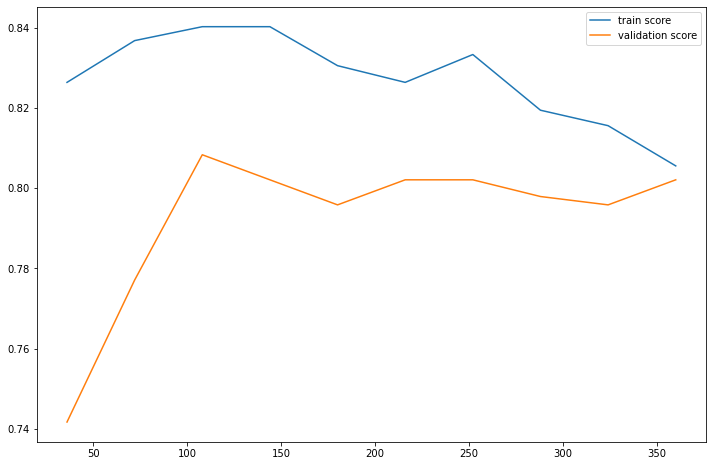

In [21]:
evaluation(model_2)

In [22]:
model_2.fit(X_train,y_train)
ypred=model_2.predict(X_test)

In [23]:
model_2.score(X_test,y_test)

0.8512396694214877

In [24]:
accuracy_score(y_test,ypred)

0.8512396694214877

In [25]:
model_2.score(X_train,y_train)

0.80625

In [26]:
model_1.fit(X_train,y_train)
ypred=model_1.predict(X_test)

In [27]:
model_1.score(X_test,y_test)

0.768595041322314

In [28]:
model_3.fit(X_train,y_train)
ypred=model_3.predict(X_test)

In [29]:
model_3.score(X_test,y_test)

0.743801652892562

In [30]:
model_3.feature_importances_

array([0.01949422, 0.02126422, 0.01631423, 0.00104686, 0.01521225,
       0.04771622, 0.02678525, 0.08720963, 0.02733912, 0.30334644,
       0.03808151, 0.06316268, 0.10724224, 0.01548388, 0.13679618,
       0.07350505])

In [33]:
pd.DataFrame(model_3.feature_importances_, index=X_train.columns)

,0
Gender,0.019494
Married,0.021264
Dependents,0.016314
Education,0.001047
Self_Employed,0.015212
ApplicantIncome,0.047716
CoapplicantIncome,0.026785
LoanAmount,0.087210
Loan_Amount_Term,0.027339
Credit_History,0.303346
